# Computer Vision - Image Stitching
#### Gerry Guinardi - 2440015556
#### Ho Michael Gunawan - 2440037771
#### Vito Pramudita Minardi - 2440060231
---

### Using the images of Taj Mahal as it is shown below, create one panoramic image using image stitching technique. Clearly write the algorithm you followed, implement your respective algorithm in python notebook and show the final combined image. You may need to install imutils python library
![image](example.jpg)


In [1]:
# import packages
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
# image path
imagePath = './images'
images = []
imagesNames = os.listdir(imagePath)

# retrieve and read image to images
for filename in imagesNames:
    image = cv2.imread(imagePath + '/' + filename)
    images.append(image)

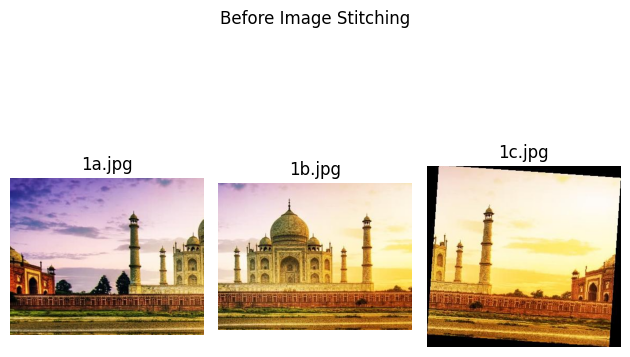

In [3]:
# show images before stitching
fig = plt.figure()
for index, image in enumerate(images):
    ax = fig.add_subplot(1, len(images), index+1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    plt.title(imagesNames[index])

fig.suptitle("Before Image Stitching")
plt.tight_layout()
plt.show()

(-0.5, 854.5, 346.5, -0.5)

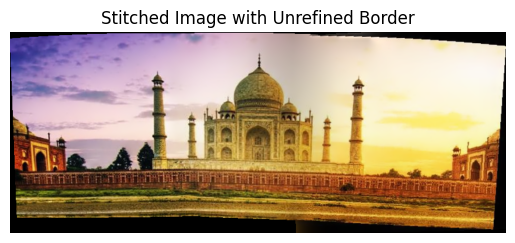

In [4]:
# Make stiched_create Method
stitcher = cv2.Stitcher_create()

# Call method to stitch images
(status, stitched) = stitcher.stitch(images)

# Show stitched image With unrefined Border
plt.title("Stitched Image with Unrefined Border")
plt.imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))
plt.axis("off")

Since the result above still has black border, we have to use method below to make it a better panoramic image.

In [5]:
def cropImage(stitched_images):
    # Create a 10 pixel border around the images
    stitched_images = cv2.copyMakeBorder(
        stitched_images, 
        10, 
        10, 
        10, 
        10, 
        cv2.BORDER_CONSTANT,
        (0, 0, 0)
        )

    # Convert the stitched image to grayscale and threshold it where all pixels intensity greater than zero are set to 255 (foreground) while all others remain 0 (background)
    gray = cv2.cvtColor(stitched_images, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

    # Find all external contours in the threshold image then find the largest contour which will be the contour/outline of the stitched image
    contour = cv2.findContours(
        thresh.copy(), 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
        )
    contour = imutils.grab_contours(contour)
    c = max(contour, key=cv2.contourArea)

    # CREATE MASK
    # Allocate memory for the mask which will contain the rectangular bounding box of the stitched image region
    mask = np.zeros(thresh.shape, dtype='uint8')
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)

    # EXTRACT PANORAMIC IMAGE USING ERODE
    # Create two copies of the mask: one to serve as our actual minimum rectangular region and another to serve as a counter for how many pixels need to be removed to form the minimum rectangular region
    minRect = mask.copy()
    sub = mask.copy()

    # Keep looping until there are no non-zero pixels left in the subtracted image
    while cv2.countNonZero(sub) > 0:
        # Erode the minimum rectangular mask and then subtract the thresholded image from the minimum rectangular mask so we can count if there are any non-zero pixels left
        minRect = cv2.erode(minRect, None)
        sub = cv2.subtract(minRect, thresh)

    # Find contours in the minimum rectangular mask and then extract the bounding box (x, y)-coordinates
    contour = cv2.findContours(
        minRect.copy(), 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_SIMPLE
        )

    contour = imutils.grab_contours(contour)
    c = max(
        contour, 
        key=cv2.contourArea
        )

    (x, y, w, h) = cv2.boundingRect(c)

    # Use the bounding box coordinates to extract the our final stitched image
    stitched_images = stitched_images[y:y + h, x:x + w]
    return stitched_images

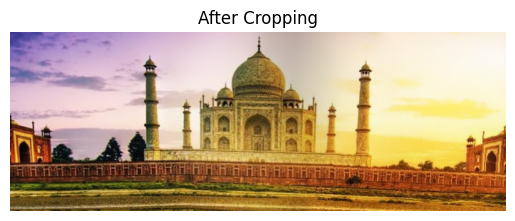

In [6]:
# Display the output of the cropped stitched image
croped_image = cropImage(stitched)
plt.title("After Cropping")
plt.imshow(cv2.cvtColor(croped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()